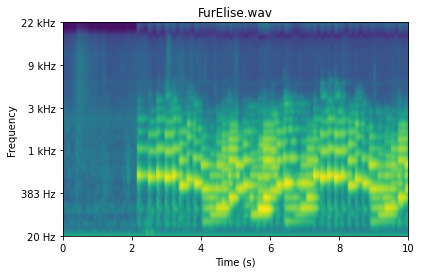

In [1]:
from os.path import join as pjoin
from gammatone.plot import render_audio_from_file
from gammatone.gtgram import gtgram
render_audio_from_file(pjoin("..", "data", "FurElise.wav"), 10, gtgram)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def read_wav(path):
    from scipy.io import wavfile

    _f, _data = wavfile.read(path)  # samplerate, data
    _N = _data.shape[0]  # number of samples (overall)
    _t = 1.0 / _f  # period between samples (in seconds)
    _T = _t * _N  # overall length (in seconds)

    print(f"File: {path}\nSamples: {_N}, rate: {_f}s^-1, period: {_t:.10f}s, length: {_T}s")
    return {"data": _data, "f": _f, "N": _N, "T": _T}

def plot_wave(title, **kwargs):
    _data, _T, _N = kwargs["data"], kwargs["T"], kwargs["N"]

    _fig, (_ax1, _ax2) = plt.subplots(2, 1, figsize=(20, 5))
    _x = np.linspace(0., _T, _N)
    for _ax, _channel, _title in [(_ax1, 0, "Left channel"),
                                  (_ax2, 1, "Right channel")]:
        _ax.plot(_x, _data[:, _channel], label=_title, linewidth=0.1, color="#1ee1db")
        _ax.legend(loc="lower right")
        _ax.grid()
        _ax.set_xlabel("Time [s]")
        _ax.set_ylabel("Amplitude")
    plt.suptitle(title)

def plot_lowpass_butterworth_filter(title, **kwargs):
    from scipy import signal
    _data, _f, _T, _N = kwargs["data"], kwargs["f"], kwargs["T"], kwargs["N"]

    _nyq = _f / 2.  # Nyquist frequency = samplerate / 2
    _cutoff = 20000  # ~ maximum frequency heard by humans
    _order = 5

    _b, _a = signal.butter(_order, _cutoff / _nyq, btype="lowpass", output="ba")
    _filtered_data = signal.lfilter(_b, _a, _data)

    # Plot the filter frequency response
    _w, _h = signal.freqz(_b, _a)
    plt.plot(0.5*_f*_w/np.pi, np.abs(_h), color="blue")
    plt.plot(_cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(_cutoff, color="black")
    plt.xlim(0, 0.5*_f)
    plt.title("Lowpass Butterworth Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

    # Plot the filtered data
    ret_val = {"data": _filtered_data, "f": _f, "N": _N, "T": _T}
    plot_wave(title, **ret_val)
    return ret_val

def plot_fft(title, **kwargs):
    from scipy.fft import rfft
    _data, _N, _f = kwargs["data"], kwargs["N"], kwargs["f"]

    _fig, (_ax1, _ax2) = plt.subplots(1, 2, figsize=(20, 5))
    for _ax, _channel, _title in [(_ax1, 0, "Left channel"),
                                  (_ax2, 1, "Right channel")]:
        _yf = np.abs(rfft(_data[:, _channel]))
        _xf = np.linspace(0., _f/2., _yf.shape[0])
        _ax.plot(_xf, _yf, label=_title, linewidth=0.5, color="#1ee1db")
        _ax.legend(loc="upper right")
        _ax.grid()
        _ax.set_xlabel("Frequency [1/s]")
        _ax.set_ylabel("Amplitude")
    plt.suptitle(title)

File: ..\data\gallop\C5-A3-C5.wav
Samples: 116352, rate: 48000s^-1, period: 0.0000208333s, length: 2.424s


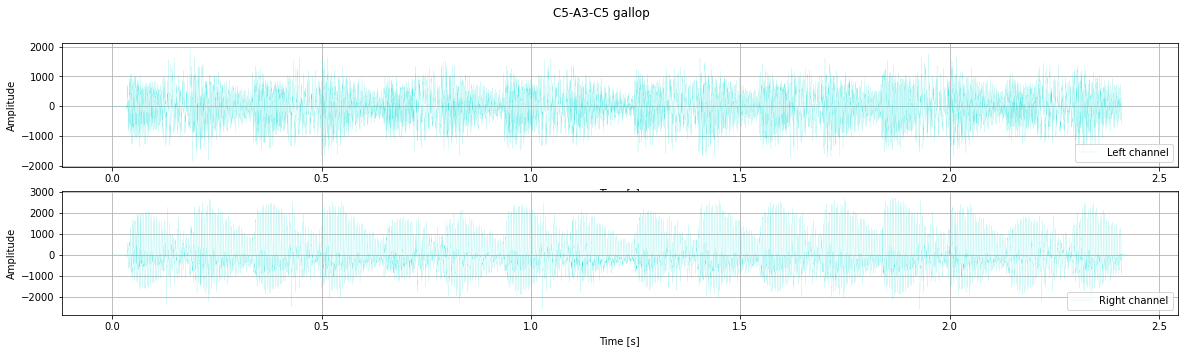

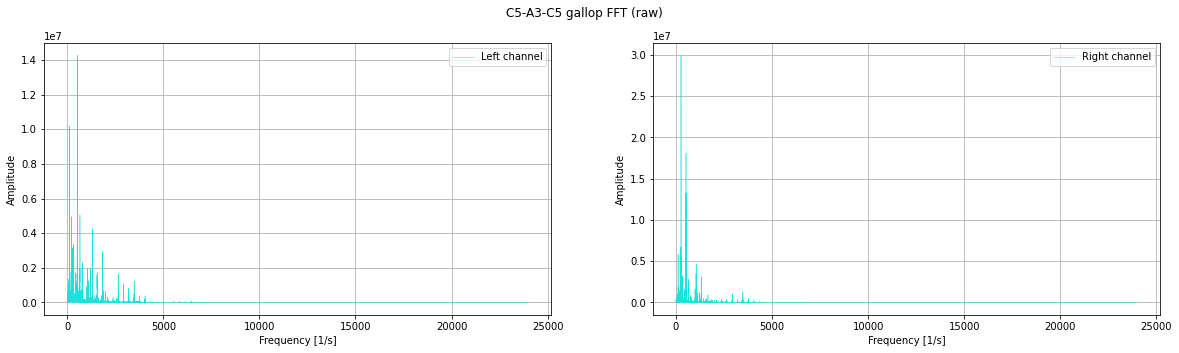

In [36]:
from os.path import join as pjoin
c5_a3_c5_raw = read_wav(pjoin("..", "data", "gallop", "C5-A3-C5.wav"))
plot_wave("C5-A3-C5 gallop", **c5_a3_c5_raw)
plot_fft("C5-A3-C5 gallop FFT (raw)", **c5_a3_c5_raw)

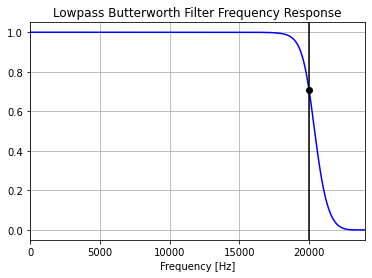

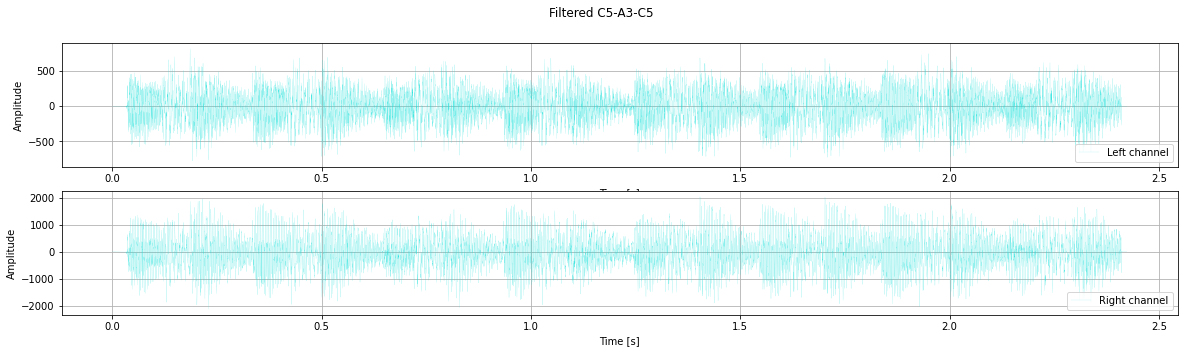

In [39]:
c5_a3_c5_lowpass_filtered = plot_lowpass_butterworth_filter("Filtered C5-A3-C5", **c5_a3_c5_raw)

In [ ]:
# TODO: try to filter out anything else besides C5 and A3?